# **AVM Müşteri Segmentasyonu Analizi (K-Means Clustering)**

## **1. Proje Özeti ve İş Problemi**

#### Bu projede, büyük bir alışveriş merkezi (AVM) yönetiminin pazarlama bütçesini daha verimli kullanabilmesi için makine öğrenmesi tabanlı müşteri segmentasyonu gerçekleştirilmiştir. Amaç, benzer harcama davranışlarına sahip müşterileri gruplamak ve her segmente özel pazarlama stratejileri geliştirilmesini sağlamaktır.

#### **Veri seti Kaggle'dan alınmıştır.**

**Veri seti:** https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data?select=Mall_Customers.csv

### Problem Tanımı 

#### AVM yönetiminin elinde aşağıdaki müşteri bilgileri bulunmaktadır:

* Gender

* Age

* Annual Income (Yıllık Gelir)

* Spending Score (Harcama Skoru – 1-100)

#### Ancak:

* Müşterilerin nasıl kategorize edileceği bilinmemektedir.

* Her müşteriye aynı kampanyayı yapmak maliyetlidir.

#### Hedef: Benzer özelliklere sahip müşterileri kümeleme (clustering) yöntemiyle gruplamak ve:

* Zengin ama az harcayanlar

* Orta gelirli ama çok harcayanlar

* Sadık müşteriler

* Düşük gelir – düşük harcama grubu

gibi segmentler oluşturmak.

### Kullanılan Kütüphaneler

* **Pandas:** Veri setinin yüklenmesi, ön işlenmesi ve tablo tabanlı veri analizinin gerçekleştirilmesi için kullanılmıştır.

* **NumPy:** Sayısal hesaplamalar ve makine öğrenmesi algoritmalarının matematiksel altyapısını sağlamak amacıyla kullanılmıştır.

* **Matplotlib:** Veri analizi ve model sonuçlarının grafikler aracılığıyla görselleştirilmesi için kullanılmıştır.

* **Seaborn:** Kümeleme sonuçlarının daha anlaşılır ve estetik biçimde görselleştirilmesi için kullanılmıştır.

* **Scikit-learn:** Müşteri segmentasyonu için K-Means kümeleme modeli ve veri ölçekleme işlemlerinin uygulanması amacıyla kullanılmıştır.



## **2. Kütüphanelerin Yüklenmesi ve Veri Seti**

In [1]:
# Kütüphaneleri Yükleme 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Veriyi Yükleme
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

## **3. Keşifsel Veri Analizi (EDA)**

In [2]:
# Genel Bakış
print("--- Veri Seti Bilgisi ---")
print(df.info())

print("\n--- İlk 5 Satır ---")
print(df.head())

# İstatistiksel Özet
print("\n--- İstatistiksel Özet ---")
print(df.describe().T)

# Eksik Değer Kontrolü
print("\n--- Eksik Değer Sayısı ---")
print(df.isnull().sum())

--- Veri Seti Bilgisi ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

--- İlk 5 Satır ---
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

---

### Veri Yapısı ve Kalitesi (Data Info)

#### * **Gözlem Sayısı:** Veri seti 200 satırdan oluşuyor. Bir makine öğrenmesi projesi için başlangıç düzeyinde, temiz ve dengeli bir örneklemdir.

#### * **Değişken Tipleri:**  4 adet sayısal (int64): CustomerID, Age, Annual Income, Spending Score. 1 adet kategorik (object): Gender.

#### * **Eksik Veri (Null Values):** Veri setinde ***hiç eksik değer (0 null)*** bulunmuyor. Bu durum, veri temizleme aşamasında bizi büyük bir yükten kurtarıyor ve verinin güvenilir olduğunu gösteriyor.


### Temel İstatistiksel Çıkarımlar (Descriptive Statistics)

#### İstatistiksel özet, müşteri profilinin sınırlarını belirler:

#### **Yaş (Age):** * Müşteriler 18 ile 70 yaş arasındadır.

#### * Ortalama yaş 38.8'dir. Yani AVM'nin ana kitlesi orta yaş grubuna yakındır.

#### **Yıllık Gelir (Annual Income):**

#### * En düşük gelir 15.000\$, 

#### * En yüksek gelir ise 137.000 \$ seviyesindedir.

#### * Ortalama gelir 60.500 $ civarındadır. Gelir dağılımında çok uç noktalar (outliers) olup olmadığının görselleştirme aşamasında kontrol edilmesi gerekir.

#### **Harcama Skoru (Spending Score):**

#### * 1 ile 99 arasında değişen bu skorda ortalama 50.2'dir.

#### * Puanların merkeze (50) yakın yoğunlaşması, müşterilerin çoğunun "ortalama harcamacı" olduğunu, ancak uçlarda çok değerli (99 puan) veya kazanılması gereken (1 puan) müşterilerin de bulunduğunu gösterir.

### İlk 5 Satır Gözlemi (Head)

#### Verinin ilk satırlarına bakıldığında:

#### * CustomerID sütunu sadece bir etiket (ID) görevindedir. Modelin öğrenme sürecine bir katkısı olmayacağı için **Feature Engineering** aşamasında bu sütunu analizden çıkaracağız.

#### * Gender sütunu "Male/Female" olarak kodlanmıştır. Gender değişkeni kategorik olduğu için sayısal olarak anlamlı bir mesafe ifade etmez. K-Means algoritması mesafe hesaplarına dayandığından encoding yapılmamıştır ve K-Means algoritmasında kullanılmamıştır.
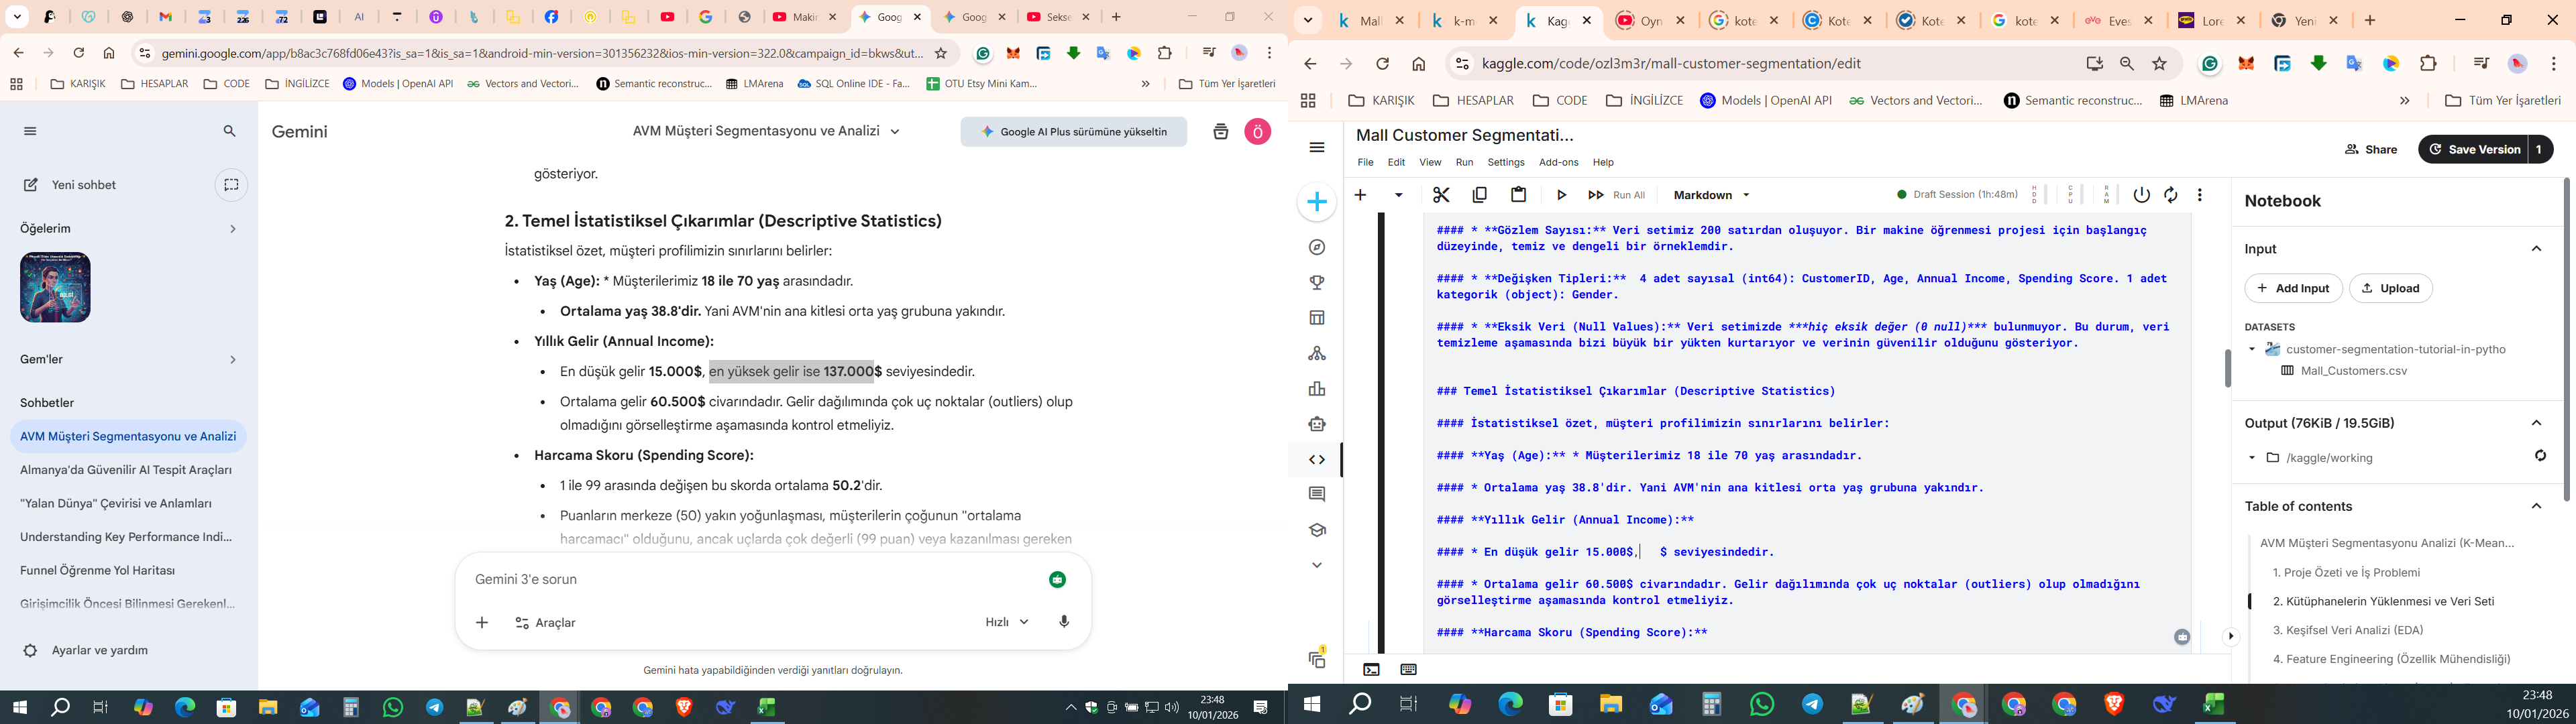

### **Görsel Analiz: Değişkenlerin Dağılımı**

#### Aşağıdaki grafiklerde veri setinde yer alan Yaş, Yıllık Gelir ve Harcama Skoru değişkenlerinin dağılımları incelenmiştir.

####  **Yaş Dağılımı**

Müşterilerin yaşlarının büyük ölçüde 20–40 yaş aralığında yoğunlaştığı görülmektedir. Daha ileri yaş gruplarında müşteri sayısı kademeli olarak azalmaktadır. Bu durum, AVM’nin genç ve orta yaş grubunu hedefleyen bir müşteri profiline sahip olduğunu göstermektedir.

####  **Yıllık Gelir Dağılımı**

Yıllık gelirler ağırlıklı olarak 30–80 bin dolar aralığında toplanmıştır. Daha yüksek gelir seviyelerinde müşteri sayısı azalmaktadır. Gelir dağılımının geniş bir aralığa yayılması, farklı ekonomik segmentlerden müşterilerin bulunduğunu göstermektedir.

####  **Harcama Skoru Dağılımı**

Harcama skoru dağılımı orta seviyelerde (40–60 aralığı) yoğunlaşmakla birlikte, düşük ve yüksek harcama alışkanlığına sahip müşteriler de bulunmaktadır. Bu durum, müşteri davranışlarının heterojen olduğunu ve segmentasyona uygun bir yapı sunduğunu göstermektedir.

####  **Genel Değerlendirme**

Bu dağılımlar, müşteri segmentasyonu için kullanılan değişkenlerin ayırt edici ve anlamlı olduğunu ortaya koymaktadır. Özellikle Yıllık Gelir ve Harcama Skoru değişkenleri, müşterilerin farklı gruplara ayrılabilmesi açısından güçlü bir temel oluşturmaktadır.

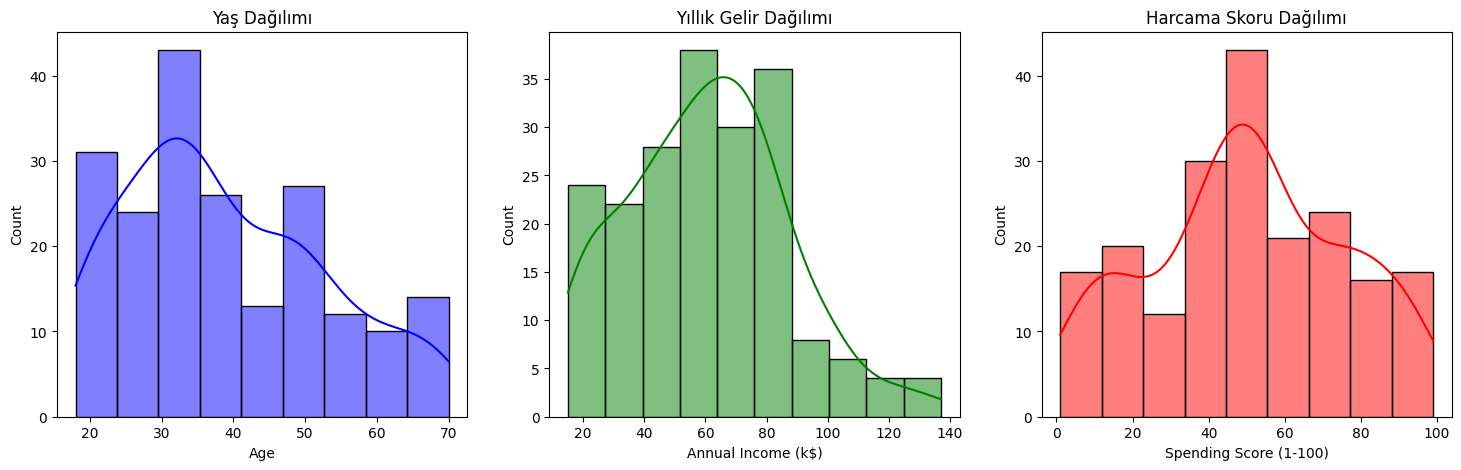

In [3]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Age'], kde=True, color='blue')
plt.title('Yaş Dağılımı')

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], kde=True, color='green')
plt.title('Yıllık Gelir Dağılımı')

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], kde=True, color='red')
plt.title('Harcama Skoru Dağılımı')

plt.show()

### **Özellikler Arası Korelasyon Analizi**

#### Aşağıdaki korelasyon ısı haritası, veri setinde yer alan değişkenler arasındaki doğrusal ilişkileri göstermektedir. Korelasyon katsayıları -1 ile +1 arasında değer almakta olup, mutlak değerin büyümesi ilişkinin gücünü ifade etmektedir.

####  **CustomerID**

CustomerID ile diğer değişkenler arasında yüksek korelasyon görülmesi, bu değişkenin yalnızca tanımlayıcı (ID) bir alan olmasından kaynaklanmaktadır. Modelleme sürecinde anlamlı bir bilgi taşımadığı için analiz dışında bırakılması uygundur.

####  **Age (Yaş)**

Yaş ile Yıllık Gelir arasında anlamlı bir korelasyon bulunmamaktadır.

Harcama Skoru arasında zayıf negatif bir korelasyon (-0.33) bulunmaktadır.

Bu durum, yaş arttıkça harcama eğiliminin kısmen azaldığını göstermektedir; ancak ilişkinin güçlü olmadığı görülmektedir.

####  **Annual Income (Yıllık Gelir)**

Yıllık gelir ile Harcama Skoru arasında neredeyse hiçbir doğrusal ilişki (≈ 0) bulunmamaktadır.

Bu sonuç, yüksek gelirli her müşterinin yüksek harcama yapmadığını ve gelir ile harcama davranışının doğrudan bağlantılı olmadığını göstermektedir.

####  **Spending Score (Harcama Skoru)**

Harcama skoru, özellikle müşteri davranışlarını ayırt etmede önemli bir değişken olup, gelirden bağımsız olarak farklı müşteri profillerinin oluşabileceğini göstermektedir.

#### **Genel Değerlendirme**

Korelasyon analizi sonucunda:

Değişkenler arasında güçlü doğrusal ilişkiler bulunmamaktadır.

Bu durum, müşteri segmentasyonu için kümeleme algoritmalarının (K-Means) uygun olduğunu göstermektedir.

Annual Income ve Spending Score değişkenleri, birbirinden bağımsız bilgi sunduğu için müşteri gruplarını ayırt etmede etkili bir kombinasyon oluşturmaktadır.

#### Not: numeric_only=True parametresi, metin içeren sütunların hata vermesini engeller.

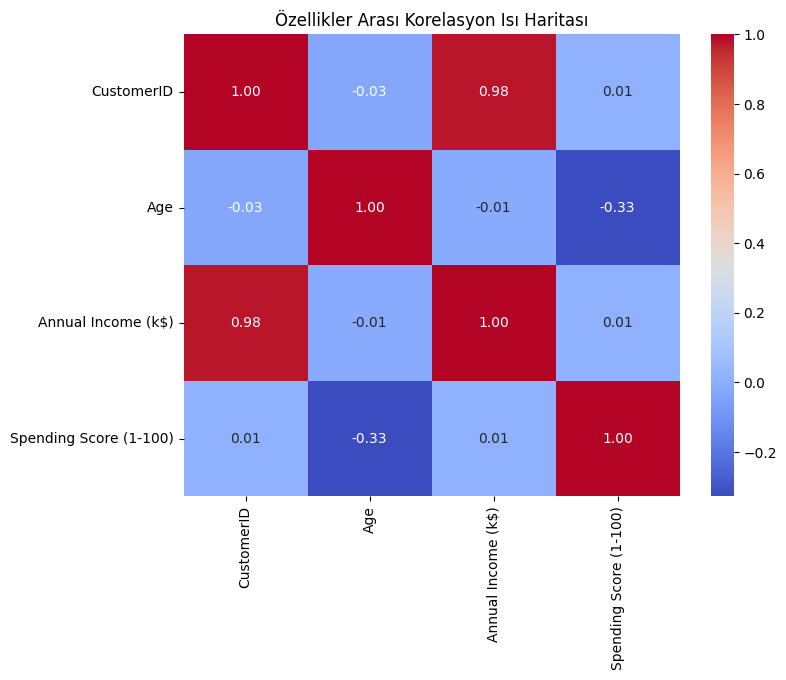

In [4]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Özellikler Arası Korelasyon Isı Haritası')
plt.show()

## **4. Feature Engineering (Özellik Mühendisliği)**

#### Ölçeklendirme, K-Means gibi mesafe tabanlı algoritmalar gözlemler arasındaki benzerliği mesafeye göre hesapladığı için kritik öneme sahiptir. Farklı ölçeklere sahip değişkenler (örneğin yıllık gelir ve harcama skoru) ölçeklendirilmediğinde, büyük değer aralığına sahip değişkenler mesafe hesaplamalarını domine eder ve model yanıltıcı kümeler oluşturur, bu nedenle tüm değişkenlerin eşit katkı sağlaması ve anlamlı müşteri segmentleri elde edilebilmesi için veriler ölçeklendirilmiştir.

In [5]:
# Kümeleme için kullanılacak özelliklerin seçilmesi
# Analizi zenginleştirmek için Yaş, Gelir ve Skoru dahil ediyoruz
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Standartlaştırma (Verileri 0-1 aralığına/benzer ölçeğe çekme)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Veri ön işleme tamamlandı ve ölçeklendirildi.")

Veri ön işleme tamamlandı ve ölçeklendirildi.


## **5. Model Seçimi ve Dirsek (Elbow) Yöntemi**

#### Kaç adet müşteri segmenti oluşturmalıyız? Dirsek yöntemi, hata oranının (WCSS) en keskin düştüğü noktayı bularak bize ideal küme sayısını verir.

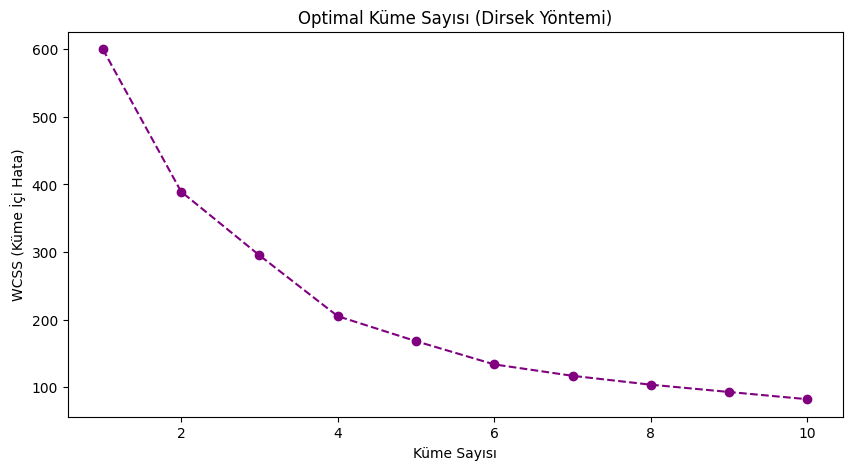

In [6]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.title('Optimal Küme Sayısı (Dirsek Yöntemi)')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS (Küme İçi Hata)')
plt.show()

### Optimal Küme Sayısının Belirlenmesi (Dirsek Yöntemi)

Bu grafikte, farklı küme sayıları için **WCSS (Within-Cluster Sum of Squares)** değerleri gösterilmektedir. WCSS, kümeler içindeki veri noktalarının merkeze olan uzaklıklarının toplamını ifade eder ve daha düşük değerler daha kompakt kümeleri temsil eder.

Grafik incelendiğinde, küme sayısı 5’e kadar WCSS değerinde belirgin bir düşüş gözlemlenmekte, bu noktadan sonra ise azalma hızının yavaşladığı görülmektedir. Bu kırılma noktası, dirsek (elbow) olarak adlandırılır ve optimal küme sayısının 5 olduğunu göstermektedir.

Bu nedenle, müşteri segmentasyonunda en dengeli ve anlamlı sonuçları elde edebilmek için model 5 küme olacak şekilde yapılandırılmıştır.

## **6. Modelin Uygulanması ve 3D Görselleştirme**

#### Yukarıdaki grafiğe göre ideal küme sayısı 5 'tir. Bu yüzden küme sayısını 5 olarak ayarlıyoruz.

In [7]:
# Final modelin kurulması
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Segment'] = kmeans.fit_predict(X_scaled)

# Segment sayılarını kontrol etme
print(df['Segment'].value_counts())

# 3D İnteraktif Görselleştirme (Plotly)
fig = px.scatter_3d(df, 
                    x='Age', 
                    y='Annual Income (k$)', 
                    z='Spending Score (1-100)',
                    color='Segment',
                    title='AVM Müşteri Segmentasyonu (3 Boyutlu)',
                    opacity=0.8,
                    color_continuous_scale='Viridis')

fig.show()

Segment
1    54
4    47
2    40
3    39
0    20
Name: count, dtype: int64


#### Yaş, Yıllık Gelir ve Harcama Skoru değişkenleri kullanılarak oluşturulan 5 farklı müşteri segmenti üç boyutlu olarak görselleştirilmiştir. Her renk, K-Means algoritması tarafından belirlenen farklı bir müşteri grubunu temsil etmektedir.

#### Segmentlerin uzamsal olarak belirgin şekilde ayrıştığı görülmektedir; bu durum modelin müşteriler arasındaki davranış farklılıklarını başarılı bir şekilde yakaladığını göstermektedir. Özellikle yüksek gelir–yüksek harcama, yüksek gelir–düşük harcama ve düşük gelir–düşük harcama profillerinin birbirinden net biçimde ayrıldığı gözlemlenmektedir.

#### Üçüncü boyut olarak yaş değişkeninin eklenmesi, benzer gelir ve harcama skorlarına sahip ancak farklı yaş gruplarında yer alan müşterilerin ayrıştırılmasına katkı sağlamış ve segmentlerin daha anlamlı yorumlanabilmesini mümkün kılmıştır. Bu sonuçlar, AVM yönetiminin her segmente özel pazarlama ve kampanya stratejileri geliştirebilmesi için güçlü bir karar destek mekanizması sunmaktadır.

**Segment 0 –** Düşük Gelir / Düşük Harcama (Düşük Değerli Müşteriler) - (Koyu Mor)

Bu segmentte yer alan müşteriler düşük yıllık gelire ve düşük harcama skoruna sahiptir. Pazarlama açısından önceliği düşük olan bu grup, genel kampanyalar ve maliyeti düşük promosyonlarla hedeflenebilir.

**Segment 1 –** Düşük Gelir / Yüksek Harcama (Sadık Müşteriler) - (Lacivert)

Gelir seviyesi düşük olmasına rağmen harcama skoru yüksek olan bu müşteriler, AVM’ye bağlılık göstermektedir. Sadakat programları ve özel indirimler ile elde tutulmaları önemlidir.

**Segment 2 –** Orta Gelir / Orta Harcama (Standart Müşteriler) - (Turkuaz)

Bu segment, AVM’nin ana müşteri kitlesini oluşturmaktadır. Dengeli gelir ve harcama profiline sahip olan bu grup için genel kampanyalar ve çapraz satış stratejileri uygundur.

**Segment 3 –** Yüksek Gelir / Düşük Harcama (Potansiyel Müşteriler) - (Açık Yeşil)

Yüksek gelir düzeyine sahip olmalarına rağmen harcama skorları düşük olan bu müşteriler, doğru pazarlama stratejileriyle daha yüksek değere dönüştürülebilir. Kişiselleştirilmiş teklifler ve premium deneyimler önerilmektedir.

**Segment 4 –** Yüksek Gelir / Yüksek Harcama (VIP Müşteriler) - (Sarı)

Bu segment, AVM için en değerli müşteri grubunu temsil etmektedir. Özel etkinlikler, kişisel kampanyalar ve ayrıcalıklı hizmetlerle bu grubun memnuniyeti ve bağlılığı artırılmalıdır.

## **7. İş Analizi ve Strateji Önerileri**

#### Son olarak, bu grupların ortalamalarına bakarak yönetim için stratejiler belirliyoruz.

In [8]:
# Her grubun özelliklerini inceleyelim
segment_analysis = df.groupby('Segment')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(segment_analysis)

               Age  Annual Income (k$)  Spending Score (1-100)
Segment                                                       
0        46.250000           26.750000               18.350000
1        25.185185           41.092593               62.240741
2        32.875000           86.100000               81.525000
3        39.871795           86.102564               19.358974
4        55.638298           54.382979               48.851064


### Segment Bazlı İş Analizi ve Pazarlama Stratejileri

Bu bölümde, K-Means algoritması ile elde edilen müşteri segmentleri analiz edilmiş ve her segment için AVM yönetimine yönelik iş değeri, fırsatlar ve stratejik aksiyonlar önerilmiştir.

#### Segment 0 – Düşük Gelir / Düşük Harcama

**İş Analizi:**
Bu segment, düşük satın alma gücü ve düşük alışveriş sıklığı nedeniyle AVM açısından sınırlı gelir potansiyeline sahiptir.

**Strateji Önerileri:**

* Genel indirim günleri ve düşük maliyetli kampanyalar

* Temel ihtiyaç odaklı mağaza ve ürün promosyonları

* Pazarlama bütçesinde düşük önceliklendirme

#### Segment 1 – Düşük–Orta Gelir / Yüksek Harcama (Sadık Müşteriler)

**İş Analizi:**
Gelir seviyesi görece düşük olmasına rağmen harcama eğilimi yüksek olan bu grup, AVM’ye güçlü bağlılık göstermektedir.

**Strateji Önerileri:**

* Sadakat kartları ve puan sistemleri

* Sıklık bazlı indirim ve kişiselleştirilmiş kampanyalar

* Uzun vadeli müşteri elde tutma (retention) odaklı stratejiler

#### Segment 2 – Yüksek Gelir / Yüksek Harcama (VIP Müşteriler)

**İş Analizi:**
Bu segment, AVM için en yüksek gelir ve kârlılık potansiyeline sahip müşteri grubudur.

**Strateji Önerileri:**

* Özel etkinlik davetleri ve VIP kampanyalar

* Kişisel alışveriş danışmanlığı

* Premium mağaza ve marka iş birlikleri

#### Segment 3 – Yüksek Gelir / Düşük Harcama (Potansiyel Müşteriler)

**İş Analizi:**
Satın alma gücü yüksek olmasına rağmen harcama düzeyi düşük olan bu müşteriler, önemli bir büyüme fırsatı sunmaktadır.

**Strateji Önerileri:**

* Kişiselleştirilmiş teklifler ve deneyim odaklı kampanyalar

* Premium hizmet tanıtımları

* Deneme ve ilk alışveriş teşvikleri

#### Segment 4 – Orta Gelir / Orta Harcama (Dengeli Müşteriler)

**İş Analizi:**
Dengeli gelir ve harcama yapısıyla AVM’nin istikrarlı müşteri kitlesini oluşturmaktadır.

**Strateji Önerileri:**

* Çapraz satış ve paket kampanyaları

* Uzun vadeli sadakat programları

* Mevsimsel ve tematik kampanyalar